# Semantic Segmentation

*General structure following [fast.ai notebook on camvid](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb)*

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import PIL

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Load Data

We use the [Berkely Deep Drive Dataset](https://bdd-data.berkeley.edu/) which contains a rich labeled dataset for image segmentation in diverse conditions (weather, city, reference car…).

In [3]:
path_data = Path('../data/bdd100k/seg')
path_lbl = path_data/'labels'
path_img = path_data/'images'

In [4]:
fnames = get_image_files(path_img, recurse = True)
fnames[:3]

[PosixPath('../data/bdd100k/seg/images/train/00e9be89-00001295.jpg'),
 PosixPath('../data/bdd100k/seg/images/train/051a273b-48b86bf6.jpg'),
 PosixPath('../data/bdd100k/seg/images/train/b0409282-a0efc7da.jpg')]

In [5]:
lbl_names = get_image_files(path_lbl, recurse = True)
lbl_names[:3]

[PosixPath('../data/bdd100k/seg/labels/train/0b4c8138-adfd774c_train_id.png'),
 PosixPath('../data/bdd100k/seg/labels/train/85774b5c-8b5d8894_train_id.png'),
 PosixPath('../data/bdd100k/seg/labels/train/327e2f77-99160976_train_id.png')]

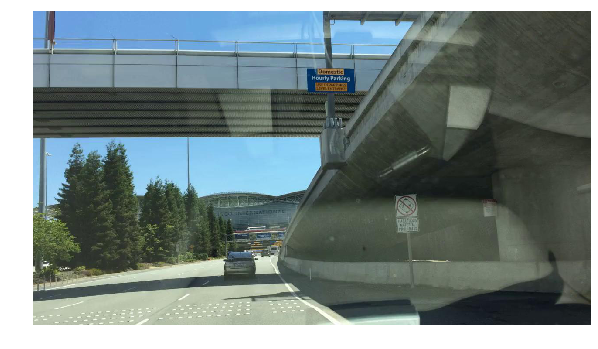

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(10,10))

In [7]:
get_y_fn = lambda x: path_lbl/x.parts[-2]/f'{x.stem}_train_id.png'

img_f, get_y_fn(img_f)

(PosixPath('../data/bdd100k/seg/images/train/00e9be89-00001295.jpg'),
 PosixPath('../data/bdd100k/seg/labels/train/00e9be89-00001295_train_id.png'))

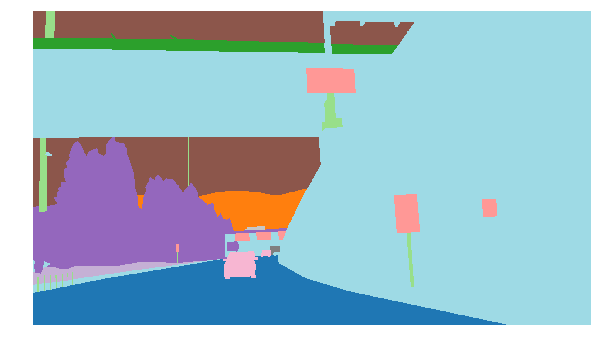

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[10, 10, 10,  ..., 19, 19, 19],
          [10, 10, 10,  ..., 19, 19, 19],
          [10, 10, 10,  ..., 19, 19, 19],
          ...,
          [ 0,  0,  0,  ..., 19, 19, 19],
          [ 0,  0,  0,  ..., 19, 19, 19],
          [ 0,  0,  0,  ..., 19, 19, 19]]]))

## Datasets

In [10]:
size = (180, 320)
bs = 16

In [11]:
# Classes extracted from dataset source code
# -> https://github.com/ucbdrive/bdd-data/blob/master/bdd_data/label.py

segmentation_classes = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
]
void_code = 19  # used to define accuracy and disconsider unlabeled pixels

In [12]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_folder(train='train', valid='val')
       .label_from_func(get_y_fn, classes = segmentation_classes))

In [13]:
src.train.y.loss_func

FlattenedLoss of CrossEntropyLoss()

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

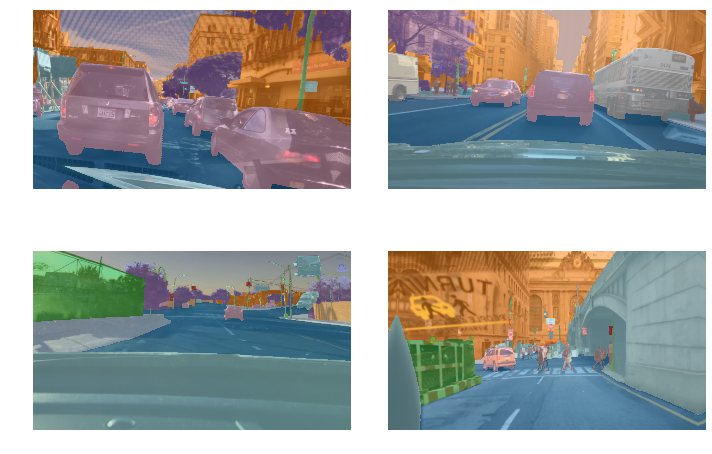

In [15]:
data.show_batch(2, figsize=(10,7))

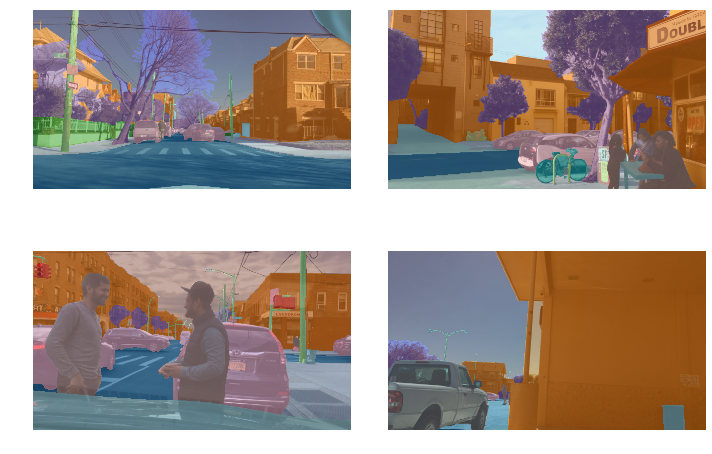

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [17]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc

In [19]:
wd=1e-5

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


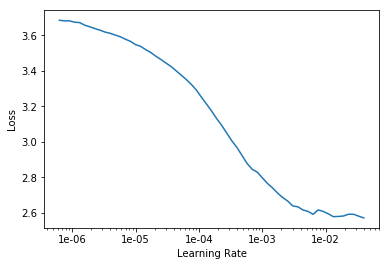

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
lr=3e-3

In [23]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,acc,time
0,0.873288,0.712908,0.832099,03:44
1,0.720297,0.579908,0.845766,03:40
2,0.623620,0.515265,0.858850,03:39


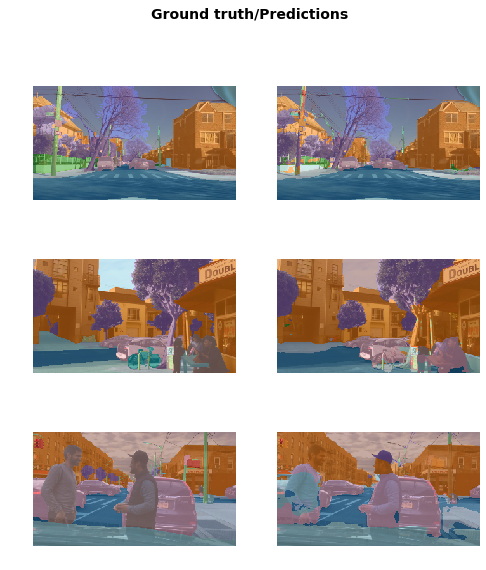

In [24]:
learn.show_results(rows=3, figsize=(8,9))

Perform fine-tuning of all layers

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(3, lrs, pct_start=0.5)

In [ ]:
learn.show_results(rows=3, figsize=(8,9))